## Gaussian Process: Yosemite Village yearly weather
_Dennis Kageni, March 2020_


---


In [ ]:
# !wget -q https://course-resources.minerva.kgi.edu/uploaded_files/mke/rj3Edn/yosemite-temperatures.zip
# !unzip -q yosemite-temperatures.zip
# !rm *.zip

This week’s assignment revisits the temperature data from Yosemite Village. This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.

1. Using a sparse Gaussian process, estimate the temperature over time of day (0:00-23:59) and time of year (1-365). Describe in detail the covariance function you chose, and why. Did you fit any hyperparameters, and if so, how?
2. Measure the mean squared error (MSE) of your Gaussian process regression, and contrast it with the MSE of your linear parameter model from a few weeks earlier. Compare and contrast the training time of your linear parameter model with the training time of the Gaussian process model.
3. Make a 3D plot showing temperature as a function of (day, time). A contour plot is also acceptable (instead of a true 3D plot).

Submit your code, and results as a pdf produced from a Python Notebook. Include relevant images or plots.

In [ ]:
import numpy as np
import pandas as pd
import GPy
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import mean_squared_error

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

<h4>Data Preprocessing</h4>

In [ ]:
years = range(2011, 2017)
files = ['yosemite_village/CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
# columns of interest are UTC_DATE(YYYYMMDD), UTC_TIME(hhmm), (AIR_TEMPERATURE)Celsius
usecols = [1, 2, 8] 

data = [np.loadtxt(f, usecols=usecols) for f in files]
data = np.vstack(data)

df = pd.DataFrame(data)

# converts dates from strings to date-time format
df[0] = pd.to_datetime(df[0], format = ('%Y%m%d'))

#converts dates from date-time format to integers from the year start
df['Day'] = df[0].dt.strftime('%j').astype(int)
df['Yr'] = df[0].dt.year

df.rename(columns={0:'Date',1:'HHmm',2:'Temp'}, inplace = True)

df_copy = df.copy()

# converting the HHmm into Minutes and storing it in 'Min'
df['Min'] = np.floor_divide(df['HHmm'], 100) * 60 + np.mod(df['HHmm'], 100)

df = df.drop(['HHmm'], axis=1)

# rearranging the dataframe
df = df[['Date','Day','Min','Temp','Yr']]

# removing the missing temp. values (-9999)
# lost ~1800 values. Have most of my data so that's okay :)
print("Original data size: {}".format(len(df)))
df = df[df.Temp != -9999.0]
print("Current size: {}".format(len(df)))



Original data size: 631296
Current size: 630854


<h4>Spliting the data into a training set of the first 5 years, and a testing set of the 6th year</h4>


In [ ]:
# train set: before 2016 
train = df[df['Yr'] < 2016]  
# test set: 2016 or after 
test = df[df['Yr'] >= 2016] 


In [ ]:
# # peek at data to check everything is okay
# display(train.head()) 
# display(test.head()) 
# display(test.tail())

Date  Day   Min  Temp    Yr
0 2011-01-01    1   5.0  -6.4  2011
1 2011-01-01    1  10.0  -6.5  2011
2 2011-01-01    1  15.0  -6.5  2011
3 2011-01-01    1  20.0  -6.5  2011
4 2011-01-01    1  25.0  -6.7  2011

Date  Day   Min  Temp    Yr
525887 2016-01-01    1   0.0  -1.6  2016
525888 2016-01-01    1   5.0  -1.9  2016
525889 2016-01-01    1  10.0  -2.0  2016
525890 2016-01-01    1  15.0  -2.1  2016
525891 2016-01-01    1  20.0  -2.2  2016

Date  Day     Min  Temp    Yr
631291 2016-12-31  366  1420.0   0.3  2016
631292 2016-12-31  366  1425.0   0.2  2016
631293 2016-12-31  366  1430.0   0.0  2016
631294 2016-12-31  366  1435.0  -0.1  2016
631295 2017-01-01    1     0.0  -0.1  2017

<h4> Question 1 </h4>
Using a sparse Gaussian process, estimate the temperature over time of day (0:00-23:59) and time of year (1-365). Describe in detail the covariance function you chose, and why. Did you fit any hyperparameters, and if so, how?

In [ ]:
# sampling 5000 data points;
# running on the entire dataset crashed the notebook

train_sample= train.sample(n = 5000) 
test_sample= test.sample(n = 1000)

# change time_train to min_train for easier understanding
days_train = train_sample['Day'].values.reshape(-1, 1)
days_test = test_sample['Day'].values.reshape(-1, 1)

min_train = train_sample['Min'].values.reshape(-1, 1)
min_test = test_sample['Min'].values.reshape(-1, 1)

X_train = train_sample[['Day', 'Min']]
X_test = test_sample[['Day', 'Min']]

y_train = train_sample['Temp'].values.reshape(-1, 1)
y_test = test_sample['Temp'].values.reshape(-1, 1)


<h5>Gaussian Process Regression for time of day:</h5>

I'm starting by fitting a full Gaussian Process. Although it has a considerable runtime, I wanted to it's log-likelihood as the benchmark for understanding the effects of the hyperparameters I'd use for the SparseGP regression


Optimization restart 1/5, f = 17281.896965082204
Optimization restart 2/5, f = 17759.795262614054
Optimization restart 3/5, f = 17281.89696467802
Optimization restart 4/5, f = 17281.896963964282
Optimization restart 5/5, f = 17759.79526183566

Name : GP regression
Objective : 17281.896963964282
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |   93.35571771780077  |      +ve      |        
  rbf.lengthscale          |   385.5247117053044  |      +ve      |        
  Gaussian_noise.variance  |  58.422684264905534  |      +ve      |        
-17281.896963964282


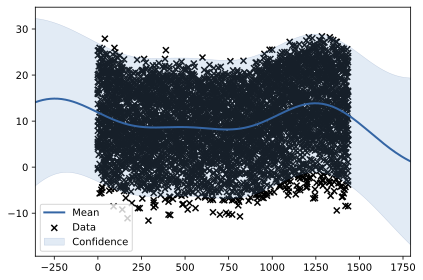

In [ ]:
k = GPy.kern.RBF(1)
m_mins_full = GPy.models.GPRegression(min_train, y_train, kernel = k)
m_mins_full.optimize_restarts(num_restarts=5)
print (m_mins_full)
m_mins_full.plot()

print (m_mins_full.log_likelihood())

<h5>SparseGP Regression for time of day:</h5>

I began by defining an RBF kernel with the default parameters. I chose the RBF covariance function as using it will result in a smooth prior on functions sampled. It is universal and robust  since it's infinitely differentiable. 


Name : sparse_gp
Objective : 413694.5326434111
Number of Parameters : 13
Number of Optimization Parameters : 13
Updates : True
Parameters:
  sparse_gp.               |    value  |  constraints  |  priors
  inducing_inputs          |  (10, 1)  |               |        
  rbf.variance             |      1.0  |      +ve      |        
  rbf.lengthscale          |      1.0  |      +ve      |        
  Gaussian_noise.variance  |      1.0  |      +ve      |        
[[-413694.53264341]] -17281.896963964282


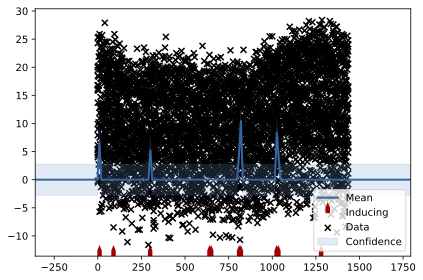

In [ ]:
k1 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

min_day_model = GPy.models.SparseGPRegression(min_train, y_train, kernel=k1)
print(min_day_model)
min_day_model.plot()


print (min_day_model.log_likelihood(), m_mins_full.log_likelihood())

SparseGP Regression Complete
Optimization restart 1/5, f = 19890.66337471281
Optimization restart 2/5, f = 17282.19640766542
Optimization restart 3/5, f = 19890.663373504587
Optimization restart 4/5, f = 19890.66338770124
Optimization restart 5/5, f = 19890.66338551912

Name : sparse_gp
Objective : 17282.19640766542
Number of Parameters : 13
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |              value  |  constraints  |  priors
  inducing_inputs          |            (10, 1)  |     fixed     |        
  rbf.variance             |  97.23012313458723  |      +ve      |        
  rbf.lengthscale          |   397.687921393742  |      +ve      |        
  Gaussian_noise.variance  |    58.429506279845  |      +ve      |        
[[-17282.19640767]] -17281.896963964282


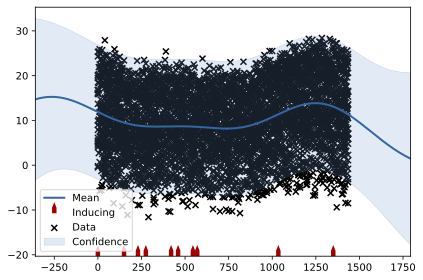

In [ ]:
# Re-run; this time optimizing the hyperparameters using the .optimize_restarts() method
kern = GPy.kern.RBF(input_dim=1, variance=1., lengthscale = 1.)

min_day_model = GPy.models.SparseGPRegression(min_train, 
                                              y_train, 
                                              kernel=kern)

print("SparseGP Regression Complete")

min_day_model.inducing_inputs.constrain_fixed() #fixing the inducing points. 
min_day_model.optimize_restarts(num_restarts=5)

print(min_day_model)
min_day_model.plot()

print (min_day_model.log_likelihood(), m_mins_full.log_likelihood())

<h5>Comments</h5>

Immediately, the fact that the model has a mean of 0 and wide confidence intervals tells us that the default parameters are not appropriate. In addition, the bound on the marginal likelihood is really broad which means our approximation is not good at all. I will now atteempt to optimize the length-scale, variance and noise componenent.

I will then proceed to implement another RBF with the following parameters:

1. **Lengthscale ($\text{l}$) = 500:** This describes how smooth a function is; where a small value means the function values will change quickly and large values characterize functions that change slowly. I would argue that the temperature change in a day falls in the latter category with a significant drop in temperature occuring over many hours. For example, it will (generally)increase from early morning, peak around midday, gradually reduce and hit a trough late at night and so on. 
2. **Signal variance ($\sigma^{2}$) = 1.0:** This determines the  variation of the function values from the mean. Given the seasonal component, we want to allow the function to accomodate outliers so we'll set it as high
3. **Noise Variance ($\sigma^{2}_{noise}$) = 0.05:** $\sigma^{2}$ I also included a noise variance to specify how much noise is expected to be present. That is, over the years on January 1st at noon, how much do we expect the average temperature for the time of day to vary? Since the temperatures are roughly expected to be similar, we use a small noise variance

SparseGP Regression Complete
Optimization restart 1/5, f = 17281.922091334643
Optimization restart 2/5, f = 19890.66339348153
Optimization restart 3/5, f = 19890.66337806367
Optimization restart 4/5, f = 19890.663385191696
Optimization restart 5/5, f = 19890.663373881343

Name : sparse_gp
Objective : 17281.922091334643
Number of Parameters : 13
Number of Optimization Parameters : 13
Updates : True
Parameters:
  sparse_gp.               |               value  |  constraints  |  priors
  inducing_inputs          |             (10, 1)  |               |        
  rbf.variance             |   94.14927780447759  |      +ve      |        
  rbf.lengthscale          |  391.63917531670796  |      +ve      |        
  Gaussian_noise.variance  |   58.40955195657921  |      +ve      |        
[[-17281.92209133]] -17281.896963964282


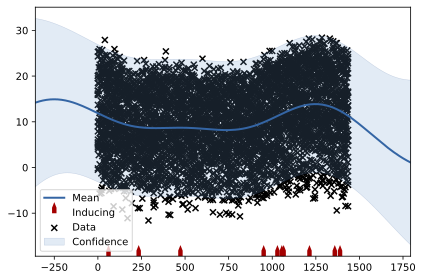

In [ ]:
noise_var = 0.05 #expected variation in average temperature input over the years

kern = GPy.kern.RBF(input_dim=1, variance=1., lengthscale = 500)

min_day_model = GPy.models.SparseGPRegression(min_train, 
                                              y_train, 
                                              kernel=kern)

print("SparseGP Regression Complete")

min_day_model.noise_var = noise_var

min_day_model.optimize_restarts(num_restarts=5)


print(min_day_model)
min_day_model.plot()


print (min_day_model.log_likelihood(), m_mins_full.log_likelihood())

The resulting MSE is:

In [ ]:
mins_train_pred = min_day_model.predict(min_train)
print("SparseGP MSE on train data: {}".format(
    mean_squared_error(y_train, mins_train_pred[0])))

SparseGP MSE on train data: 58.34634691607007


In [ ]:
# Finding the effect of increasing the inducing points on the MSE

SGP_vals = []
inducing_points = [10,50,100,150,200,250,300]

for points in inducing_points:
    min_day_model = GPy.models.SparseGPRegression(min_train,
                                                  y_train, 
                                                  kernel=kern,
                                                  num_inducing = points)
    min_day_model.noise_var = noise_var 
    min_day_model.optimize_restarts(num_restarts = 3, verbose=False)
    mins_train_pred = min_day_model.predict(min_train)[0]
    SGP_vals.append(mean_squared_error(mins_train_pred,y_train))

In [ ]:
SGP_vals

[58.34538284738595,
 58.34538245957033,
 58.34538244194142,
 58.3453824277866,
 58.34538241384833,
 58.345382400310925,
 58.34538238662058]

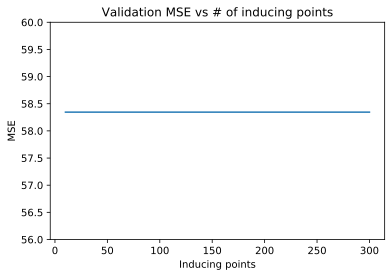

In [ ]:
plt.plot(inducing_points,SGP_vals)
plt.ylim(56,60)
plt.xlabel("Inducing points")
plt.ylabel("MSE")
plt.title("Validation MSE vs # of inducing points")
plt.show()

So really, the number of inducing points has little effect on the MSE. What I found interesting however was after making the inducing points to be spaced qually along the span of the x-axis and fixing them using the `inducing_inputs.constrain_fixed()` method, the MSE massively improved from 168 to 56.

SparseGP Regression Complete
Optimization restart 1/5, f = 17281.89729023305
Optimization restart 2/5, f = 17281.89729023189
Optimization restart 3/5, f = 19890.66337447711
Optimization restart 4/5, f = 19890.66337306278
Optimization restart 5/5, f = 19890.66339086683

Name : sparse_gp
Objective : 17281.89729023189
Number of Parameters : 13
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |               value  |  constraints  |  priors
  inducing_inputs          |             (10, 1)  |     fixed     |        
  rbf.variance             |   93.36840116009677  |      +ve      |        
  rbf.lengthscale          |    385.552683318014  |      +ve      |        
  Gaussian_noise.variance  |  58.422689414444065  |      +ve      |        
Time taken: 61.718
[[-17281.89729023]] -17281.896963964282


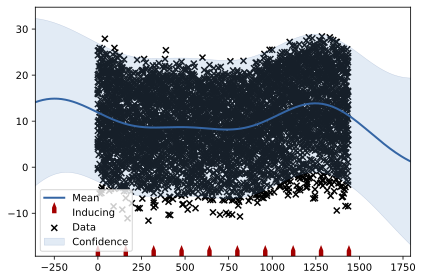

In [ ]:
# using knowledge to fit optimal inducing points

noise_var = 0.05 #expected variation in average temperature input over the years

#keeping the inducing points at 10, but making them equally spaced and fixing them
Z = np.hstack((np.linspace(0,1440,10)))[:,None]
kern_1 = GPy.kern.RBF(input_dim=1, variance=1., lengthscale = 500)

start = time.time()
min_day_model = GPy.models.SparseGPRegression(min_train, 
                                       y_train, 
                                       kernel=kern_1, 
                                       Z=Z)
print("SparseGP Regression Complete")
min_day_model.noise_var = noise_var
min_day_model.inducing_inputs.constrain_fixed() #fixing inducing points
min_day_model.optimize_restarts(num_restarts=5)

time_SGP = time.time()

print(min_day_model)
min_day_model.plot()

min_day_time = (time_SGP - start)

print("Time taken: %0.3f" % (min_day_time))
print(min_day_model.log_likelihood(), m_mins_full.log_likelihood())


<h5>GP Regression for time of year:</h5>

Optimization restart 1/5, f = 15266.904886179562
Optimization restart 2/5, f = 17549.347005679985
Optimization restart 3/5, f = 17426.265665036022
Optimization restart 4/5, f = 15403.036969512112
Optimization restart 5/5, f = 22887.04254721129

Name : GP regression
Objective : 15266.904886179562
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.            |                 value  |  constraints  |  priors
  std_periodic.variance     |     83.96010761986619  |      +ve      |        
  std_periodic.period       |     365.7329425860304  |      +ve      |        
  std_periodic.lengthscale  |  0.043719558525516164  |      +ve      |        
  Gaussian_noise.variance   |     24.45997302533222  |      +ve      |        
-15266.904886179562


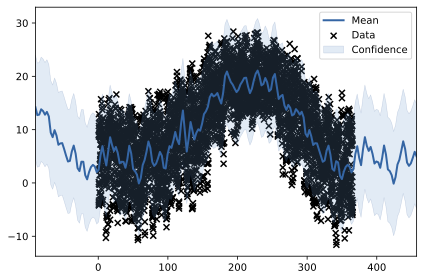

In [ ]:
k = GPy.kern.StdPeriodic(1, period=366.0)
day_year_model_full = GPy.models.GPRegression(days_train, y_train, kernel = k)
day_year_model_full.optimize_restarts(num_restarts=5)
print (day_year_model_full)
day_year_model_full.plot()  

print(day_year_model_full.log_likelihood())

<h5>SparseGP Regression for time of year:</h5>

Selected the periodic kernel because it's suitable for modelling functions that repeat themselves. This is true for temperature values across different years since seasons generally start and end in the same order over many years. This is also why I set the period parameter to 366 to encode repetitions on an annual basis.  

The implentation below is with the default parameters:


Name : sparse_gp
Objective : 73194.87466070545
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  sparse_gp.                |    value  |  constraints  |  priors
  inducing_inputs           |  (10, 1)  |               |        
  std_periodic.variance     |      1.0  |      +ve      |        
  std_periodic.period       |    366.0  |      +ve      |        
  std_periodic.lengthscale  |      1.0  |      +ve      |        
  Gaussian_noise.variance   |      1.0  |      +ve      |        
Time taken: 0.299
[[-73194.87466071]] -15266.904886179562


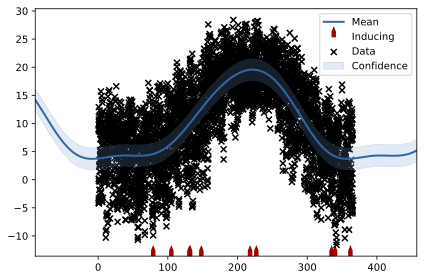

In [ ]:
## time of year GP with default values

kern_ = GPy.kern.StdPeriodic(1, period=366.0)

start = time.time()
day_year_model = GPy.models.SparseGPRegression(days_train, y_train, kernel=kern_)


time_GP = time.time()

print(day_year_model)
day_year_model.plot()

print("Time taken: %0.3f" % (time_GP - start))

print (day_year_model.log_likelihood(), day_year_model_full.log_likelihood())

I will then proceed to implement another Periodic Kernel with the following parameters:

1. **Lengthscale ($\text{l}$) = 0.01:** Set it really low because I expect the function not to be smooth
2. **Signal variance ($\sigma^{2}$) = 1.0:** This determines the  variation of the function values from the mean. Given the seasonal component, we want to allow the function to accomodate outliers so we'll set it as high
3. **Noise Variance ($\sigma^{2}_{noise}$) = 0.05:** $\sigma^{2}$ Set this to a low value since I expect little variation of the average temperature of a day over many years

Optimization restart 1/3, f = 15337.703369131903
Optimization restart 2/3, f = 31264.199491824533
Optimization restart 3/3, f = 17426.689984067685

Name : sparse_gp
Objective : 15337.703369131903
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  sparse_gp.                |                value  |  constraints  |  priors
  inducing_inputs           |              (10, 1)  |               |        
  std_periodic.variance     |    81.15869614758357  |      +ve      |        
  std_periodic.period       |    389.3819420789264  |      +ve      |        
  std_periodic.lengthscale  |  0.47360095223478416  |      +ve      |        
  Gaussian_noise.variance   |   26.716041463184574  |      +ve      |        
Time taken: 155.671
[[-15337.70336913]] -15266.904886179562


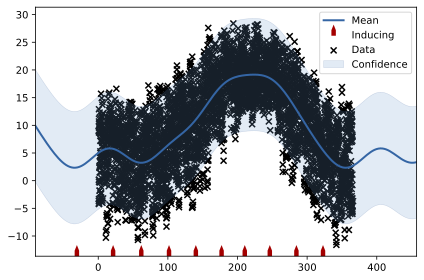

In [ ]:
noise_var = 0.05

kern_ = GPy.kern.StdPeriodic(1, lengthscale = 0.01, period=366.0)

start = time.time()
day_year_model = GPy.models.SparseGPRegression(days_train, y_train, kernel=kern_)

day_year_model.noise_var = noise_var
day_year_model.optimize_restarts(num_restarts=3)

time_GP = time.time()
print(day_year_model)
day_year_model.plot()

print("Time taken: %0.3f" % (time_GP - start))

print (day_year_model.log_likelihood(), day_year_model_full.log_likelihood())

In [ ]:
days_train_pred = day_year_model.predict(days_train)
print("SparseGP MSE on train data: {}".format(
    mean_squared_error(y_train, days_train_pred[0])))

SparseGP MSE on train data: 26.6500624972163


In [ ]:
# Find MSE for range of inducing points; use that to influcence inducing points for next run.
SGP_vals_ = []

for points in inducing_points:
    day_year_model = GPy.models.SparseGPRegression(days_train,
                                                   y_train,
                                                   kernel=kern_,
                                                   num_inducing = points)
    day_year_model.noise_var = noise_var 
    day_year_model.optimize_restarts(num_restarts = 3, verbose=False)
    days_train_pred = day_year_model.predict(days_train)[0]
    SGP_vals_.append(mean_squared_error(days_train_pred,y_train))

 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:131: RuntimeWarning:overflow encountered in true_divide
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:invalid value encountered in sin
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:148: RuntimeWarning:overflow encountered in true_divide
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:150: RuntimeWarning:invalid value encountered in sin
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:invalid value encountered in cos
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:overflow encountered in true_divide
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:181: RuntimeWarning:overflow encountered in true_divide
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:181: RuntimeWarning:invalid value

In [ ]:
SGP_vals_

[26.790697984891874,
 25.311725387193054,
 24.09507467650524,
 24.066552165452396,
 24.065048244949978,
 24.06510983192149,
 24.06508786342005]

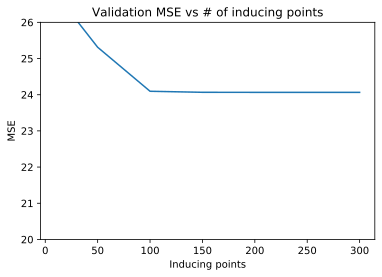

In [ ]:
plt.plot(inducing_points,SGP_vals_)
plt.ylim(20, 26)
plt.xlabel("Inducing points")
plt.ylabel("MSE")
plt.title("Validation MSE vs # of inducing points")
plt.show()

Again, there isn't a noticeable effect of increasing the inducing points beyond 100 on the MSE. But similar to last time, I observed that the MSE improved from 26 to 24 after spacing the inducing points equally on the x-axis and fixing them

 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:overflow encountered in true_divide
Optimization restart 1/5, f = 15267.772973693318
Optimization restart 2/5, f = 17427.025170305147
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:overflow encountered in square
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:151: RuntimeWarning:overflow encountered in square
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:divide by zero encountered in true_divide
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:155: RuntimeWarning:divide by zero encountered in true_divide
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:163: RuntimeWarning:invalid value encountered in multiply
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:168: RuntimeWarning:invalid value encountered in mu

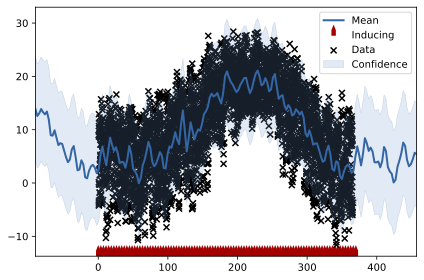

In [ ]:
noise_var = 0.05
#setting 100 inducing points, equally spaced
Z = np.hstack((np.linspace(0,370,100)))[:,None]

kern_2 = GPy.kern.StdPeriodic(1, lengthscale = 0.01, period=366.0)

start = time.time()
day_year_model = GPy.models.SparseGPRegression(days_train, y_train, kernel=kern_2, Z=Z)

day_year_model.noise_var = noise_var
day_year_model.inducing_inputs.constrain_fixed() #fixing inducing points
day_year_model.optimize_restarts(num_restarts=5)

time_GP = time.time()
print(day_year_model)
day_year_model.plot()

day_year_time = (time_GP - start)

print("Time taken: %0.3f" % (day_year_time))

print (day_year_model.log_likelihood(), day_year_model_full.log_likelihood())

<h4> Question 2 </h4>
Measure the mean squared error (MSE) of your Gaussian process regression, and contrast it with the MSE of your linear parameter model from a few weeks earlier. Compare and contrast the training time of your linear parameter model with the training time of the Gaussian process model.

In [ ]:
mins_train_pred = min_day_model.predict(min_train)
mins_test_pred = min_day_model.predict(min_test)

days_train_pred = day_year_model.predict(days_train)
days_test_pred = day_year_model.predict(days_test)

print("Time of Day model:")
print("\t" "Time taken: {} seconds".format(min_day_time))
print("\t" "SparseGP MSE on train data: {}".format(
    mean_squared_error(y_train, mins_train_pred[0])))

print("\t" "SparseGP MSE on test data {}".format(
    mean_squared_error(y_test, mins_test_pred[0])))
print("__________", '\n')

print("Time of Year model:")
print("\t" "Time taken: {} seconds".format(day_year_time))
print("\t" "SparseGP MSE on train data: {}".format(
    mean_squared_error(y_train, days_train_pred[0])))

print("\t" "SparseGP MSE on test data: {}".format(
    mean_squared_error(y_test, days_test_pred[0])))



Time of Day model:
	Time taken: 61.71781802177429 seconds
	SparseGP MSE on train data: 58.34539537136732
	SparseGP MSE on test data 59.865607734169075
__________ 

Time of Year model:
	Time taken: 102.12080383300781 seconds
	SparseGP MSE on train data: 26.751105612638327
	SparseGP MSE on test data: 26.058538282055206


<h5>Comment</h5>

The MSE values for both the time of day model and time of year model are similar to the MSE values I got from the linear parameter model from the previous assignment. However, the biggest difference is observed in the time taken where the linear parameter model is significantly faster than the Sparse Gaussian process. The Gaussian Process models run for about 50 minutes each! Therefore, while the Gaussian Process model in GPy is more advantageous given it's more robust and has more features than what I saw in scikit.learn's LPM, it's main drawback is speed. 

<h4>Question 3</h4>
Make a 3D plot showing temperature as a function of (day, time). A contour plot is also acceptable (instead of a true 3D plot)

 /opt/venv/lib/python3.7/site-packages/GPy/core/gp.py:87: UserWarning:Your kernel has a different input dimension 1 then the given X dimension 2. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel
Optimization restart 1/5, f = 15342.710680051783
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:131: RuntimeWarning:overflow encountered in true_divide
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:132: RuntimeWarning:invalid value encountered in sin
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:148: RuntimeWarning:overflow encountered in true_divide
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:150: RuntimeWarning:invalid value encountered in sin
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard_periodic.py:153: RuntimeWarning:invalid value encountered in cos
 /opt/venv/lib/python3.7/site-packages/GPy/kern/src/standard

{'inducing': <mpl_toolkits.mplot3d.art3d.Path3DCollection at 0x7f6057b5c470>,
 'gpmean': [<mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f6057b5c7b8>]}

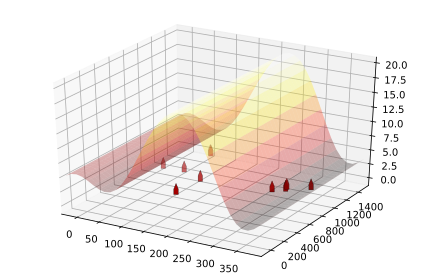

In [ ]:
## both
X_train_arr = X_train.values
X_test_arr = X_test.values

kernels = kern_1 + kern_2

both_models = GPy.models.SparseGPRegression(X_train_arr,
                                            y_train,
                                            kernel=kernels) 
both_models.noise_var = noise_var
both_models.inducing_inputs.fix()
both_models.optimize_restarts(num_restarts = 5)

print(both_models)
both_models.plot(plot_data=False, projection='3d', legend=False)


 /opt/venv/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'inducing': <matplotlib.collections.PathCollection at 0x7f6057f53c50>,
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f6057f53fd0>]}

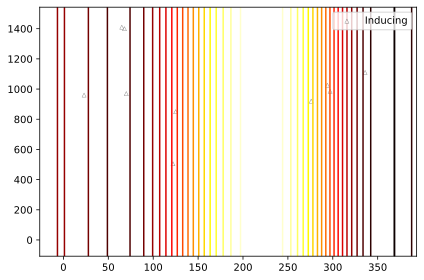

In [ ]:
both_models.plot(plot_data=False)